# Notebook de análisis (5 análisis de `analisis/old`)

Este notebook agrupa y ordena los 5 análisis históricos de la carpeta `analisis/old` en una secuencia reproducible.

Objetivo:
- Cargar los CSV de benchmark.
- Reutilizar una sola vez imports/carga/helpers.
- Ejecutar cada análisis en su propia celda (sin duplicar código) y con explicación de qué se hace y por qué sirve.

## 0) Configuración

Esta celda define rutas y parámetros comunes.

Sirve para:
- Evitar hardcodear rutas en cada análisis.
- Hacer el notebook más reproducible si se ejecuta desde otra carpeta.

In [14]:
from pathlib import Path

# El notebook está en `analisis/`. Normalmente los CSV están en esta carpeta
# o en la raíz del proyecto.
NOTEBOOK_DIR = Path.cwd()
SEARCH_DIRS = [NOTEBOOK_DIR, NOTEBOOK_DIR.parent]

CSV_GRANULAR = "benchmark_granular.csv"
CSV_RESULTS = "benchmark_results.csv"  # opcional (algunos análisis antiguos lo usan)

# Parámetro físico aproximado usado por algunos análisis antiguos
L3_APPROX_BYTES = 20 * 1024 * 1024
INT_BYTES = 4
L3_APPROX_ELEMENTS = L3_APPROX_BYTES // INT_BYTES

L3_APPROX_ELEMENTS

5242880

## 1) Imports + carga de datos + helpers (sin repetición)

Esta celda concentra todo lo reutilizable:
- imports
- funciones de carga robusta (busca el CSV en `analisis/` y en la raíz)
- helpers de filtrado/métricas/plots

Sirve para que los 5 análisis siguientes sean celdas cortas que llaman helpers.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

sns.set_theme(style="whitegrid")
plt.rcParams.update({"font.size": 10})


def _find_csv(name: str, search_dirs: list[Path]) -> Path | None:
    for d in search_dirs:
        p = d / name
        if p.exists():
            return p
    return None


def load_csv(name: str, search_dirs: list[Path]) -> pd.DataFrame | None:
    p = _find_csv(name, search_dirs)
    if p is None:
        print(f"No encontrado: {name} (buscado en: {[str(d) for d in search_dirs]})")
        return None
    return pd.read_csv(p)


def ensure_numeric(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    df = df.copy()
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df


def load_granular() -> pd.DataFrame | None:
    df = load_csv(CSV_GRANULAR, SEARCH_DIRS)
    if df is None:
        return None
    df = ensure_numeric(
        df,
        [
            "Threads",
            "InputSize",
            "TotalTime",
            "SortPhase",
            "PivotPhase",
            "SubpartPhase",
            "OffsetPhase",
            "MergePhase",
        ],
    )
    return df


def load_results() -> pd.DataFrame | None:
    df = load_csv(CSV_RESULTS, SEARCH_DIRS)
    if df is None:
        return None
    df = ensure_numeric(df, ["Threads", "InputSize", "TimeSeconds"])
    return df


def only_samplemerge(df: pd.DataFrame) -> pd.DataFrame:
    return df[df["Algorithm"] == "SampleMerge"].copy()


def add_size_label(df: pd.DataFrame, col: str = "InputSize") -> pd.DataFrame:
    df = df.copy()
    df["SizeLabel"] = df[col].apply(lambda x: f"{x:.0e}")
    return df


def effective_bandwidth_gbs(input_size: pd.Series, merge_ms: pd.Series, elem_bytes: int = 4) -> pd.Series:
    # GB/s = (N * bytes) / (time_ms * 1e-3) / 1e9
    return (input_size * elem_bytes) / (merge_ms * 1e-3) / 1e9


def ols_fit(y: pd.Series, x: pd.Series):
    return sm.OLS(y, sm.add_constant(x)).fit()


def is_nonempty(df: pd.DataFrame | None) -> bool:
    return df is not None and not df.empty


df_granular = load_granular()
df_results = load_results()

print("df_granular:", None if df_granular is None else df_granular.shape)
print("df_results:", None if df_results is None else df_results.shape)

df_granular: (7560, 10)
df_results: (304, 5)


## 1.1) Helpers adicionales (filtros y validación)

Sirve para:
- Reutilizar filtros típicos (SampleMerge/Distribución/Tamaño/Hilos) en los 5 análisis.
- Hacer que las celdas de análisis sean cortas y legibles.

In [39]:
def require_columns(df: pd.DataFrame, cols: list[str], df_name: str = "df") -> bool:
    missing = [c for c in cols if c not in df.columns]
    if missing:
        print(f"Faltan columnas en {df_name}: {missing}")
        return False
    return True


def max_input_size(df: pd.DataFrame) -> int:
    return int(pd.to_numeric(df["InputSize"], errors="coerce").max())


def subset_granular(
    df: pd.DataFrame,
    algorithm: str | None = None,
    distribution: str | None = None,
    threads: int | None = None,
    input_size: int | None = None,
) -> pd.DataFrame:
    out = df.copy()
    if algorithm is not None:
        out = out[out["Algorithm"] == algorithm]
    if distribution is not None:
        out = out[out["Distribution"] == distribution]
    if threads is not None:
        out = out[out["Threads"] == threads]
    if input_size is not None:
        out = out[out["InputSize"] == input_size]
    return out.copy()


def show_or_explain(condition: bool, message: str):
    if not condition:
        print(message)

print("Helpers adicionales listos.")

Helpers adicionales listos.


## 2) Análisis 1 — Vista general (benchmark_results.csv)

Basado en `plot_results.py`.

Sirve para:
- Ver la tendencia global tiempo vs tamaño.
- Comparar speedup contra `std::sort`.
- Ver strong scaling y efecto de la distribución (Uniform vs Normal).

Nota: Este análisis usa `benchmark_results.csv` (si no existe, se omite).

Figura A: benchmark_results.csv (ok: ratio≈1.01)


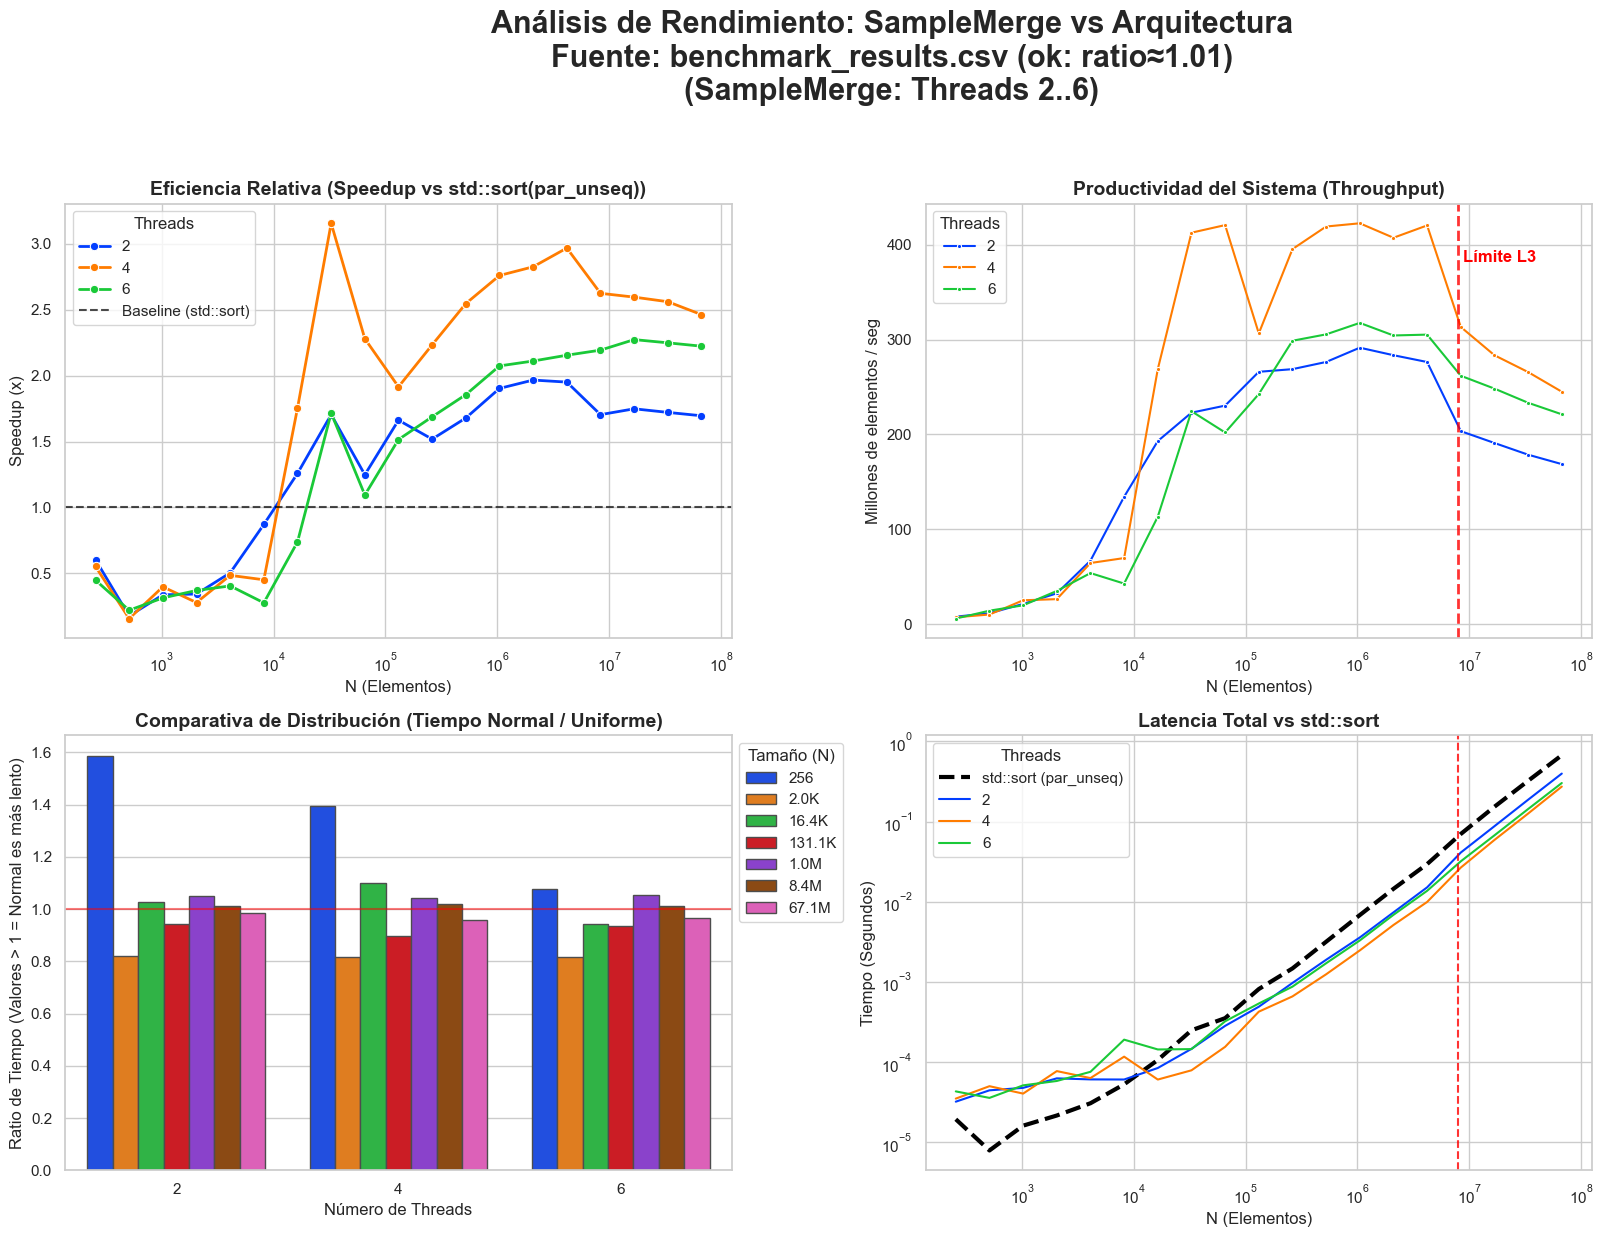

In [43]:
# Análisis 1 (general): gráfico 2x2 basado en benchmark_results.csv.
# Nota: se mantiene (si existe) una validación de unidades contra benchmark_granular.csv,
# pero NO se grafica una segunda figura con granular.

def _granular_as_results(df_g: pd.DataFrame) -> pd.DataFrame | None:
    needed = ["Algorithm", "Distribution", "Threads", "InputSize", "TotalTime"]
    if not is_nonempty(df_g) or not require_columns(df_g, needed, "df_granular"):
        return None

    df_tmp = df_g[needed].copy()
    df_tmp["TimeSeconds"] = df_tmp["TotalTime"] / 1000.0

    # En granular hay múltiples filas por punto: agregamos por mediana
    return (
        df_tmp.groupby(["Algorithm", "Distribution", "Threads", "InputSize"], as_index=False)["TimeSeconds"]
        .median()
    )


def _maybe_fix_units_using_granular(df_r: pd.DataFrame, df_g: pd.DataFrame) -> tuple[pd.DataFrame, str]:
    """Ajusta unidades de TimeSeconds si detecta que está en ms comparándolo con granular (en segundos)."""
    df_ref = _granular_as_results(df_g)
    if df_ref is None or df_ref.empty:
        return df_r, "(sin validación contra granular)"

    keys = ["Algorithm", "Distribution", "Threads", "InputSize"]
    merged = df_r.merge(df_ref, on=keys, suffixes=("_r", "_g"))
    merged = merged.dropna(subset=["TimeSeconds_r", "TimeSeconds_g"])

    if merged.empty:
        return df_r, "(sin puntos comunes para validar)"

    ratio = (merged["TimeSeconds_r"] / merged["TimeSeconds_g"]).replace([np.inf, -np.inf], np.nan).dropna()
    if ratio.empty:
        return df_r, "(validación sin ratio utilizable)"

    med_ratio = float(ratio.median())

    # Heurística: si está cerca de 1000 -> df_r está en milisegundos
    if 800 <= med_ratio <= 1200:
        df_fixed = df_r.copy()
        df_fixed["TimeSeconds"] = df_fixed["TimeSeconds"] / 1000.0
        return df_fixed, f"(corregido: TimeSeconds parecía estar en ms; ratio≈{med_ratio:.1f})"

    return df_r, f"(ok: ratio≈{med_ratio:.3g})"


def format_n_label(n):
    """Formatea N para que sea legible en tamaños pequeños (K) y grandes (M)."""
    if n >= 1e6:
        return f"{n/1e6:.1f}M"
    elif n >= 1e3:
        return f"{n/1e3:.1f}K"
    else:
        return str(int(n))


def _plot_thesis_final_v2(df: pd.DataFrame, title_suffix: str, t_min: int = 2, t_max: int = 6):
    # --- 1. Preparación de Datos ---
    df = df.copy()
    for col in ["Threads", "InputSize", "TimeSeconds"]:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df = df.dropna(subset=["Algorithm", "Distribution", "Threads", "InputSize", "TimeSeconds"])

    # Baseline: std::sort (usamos Uniform)
    std_base = df[(df["Algorithm"] == "std::sort") & (df["Distribution"] == "Uniform")]
    std_base = std_base.groupby("InputSize")["TimeSeconds"].median().reset_index()
    std_base.rename(columns={"TimeSeconds": "T_std"}, inplace=True)

    # SampleMerge
    df_sm = df[(df["Algorithm"] == "SampleMerge") & (df["Threads"] >= t_min) & (df["Threads"] <= t_max)].copy()
    df_sm = df_sm.merge(std_base, on="InputSize")
    df_sm["Speedup"] = df_sm["T_std"] / df_sm["TimeSeconds"]
    df_sm["Throughput"] = (df_sm["InputSize"] / df_sm["TimeSeconds"]) / 1e6

    # --- 2. Configuración Global ---
    sns.set_theme(style="whitegrid")
    # Límite L3 Ryzen 5600X (32MB / 4 bytes por int = 8M elementos)
    l3_limit = 8e6
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 13))
    fig.suptitle(f"Análisis de Rendimiento: SampleMerge vs Arquitectura\n{title_suffix}\n(SampleMerge: Threads {t_min}..{t_max})", fontsize=22, fontweight='bold')

    # ========================================================
    # 1. SPEEDUP VS N (Eje X = N, Líneas = Threads)
    # ========================================================
    ax1 = axes[0, 0]
    data_speed = df_sm[df_sm["Distribution"] == "Uniform"].sort_values(["Threads", "InputSize"])
    sns.lineplot(data=data_speed, x="InputSize", y="Speedup", hue="Threads",
                 palette="bright", marker="o", linewidth=2, ax=ax1)
    
    ax1.axhline(1.0, color="black", linestyle="--", alpha=0.7, label="Baseline (std::sort)")
    ax1.set_xscale("log")
    ax1.set_xlabel("N (Elementos)")
    ax1.set_title("Eficiencia Relativa (Speedup vs std::sort(par_unseq))", fontsize=14, fontweight='bold')
    ax1.set_ylabel("Speedup (x)")
    ax1.legend(title="Threads", loc="upper left", frameon=True)

    # ========================================================
    # 2. THROUGHPUT CON LÍMITE L3
    # ========================================================
    ax2 = axes[0, 1]
    sns.lineplot(data=df_sm[df_sm["Distribution"] == "Uniform"], x="InputSize", y="Throughput",
                 hue="Threads", palette="bright", marker=".", ax=ax2)
    
    ax2.axvline(x=l3_limit, color='red', linestyle='--', alpha=0.8, linewidth=2)
    ax2.text(l3_limit*1.1, df_sm["Throughput"].max()*0.9, "Límite L3", color='red', fontweight='bold')
    
    ax2.set_xscale("log")
    ax2.set_title("Productividad del Sistema (Throughput)", fontsize=14, fontweight='bold')
    ax2.set_ylabel("Millones de elementos / seg")
    ax2.set_xlabel("N (Elementos)")

    # ========================================================
    # 3. SENSIBILIDAD A DISTRIBUCIÓN (Barras Agrupadas)
    # ========================================================
    ax3 = axes[1, 0]
    dist_pivot = df_sm.pivot_table(index=["Threads", "InputSize"],
                                   columns="Distribution", values="TimeSeconds").reset_index()
    
    if "Normal" in dist_pivot.columns and "Uniform" in dist_pivot.columns:
        dist_pivot["Ratio"] = dist_pivot["Normal"] / dist_pivot["Uniform"]
        
        # Seleccionamos 6-7 tamaños para que las barras sean legibles
        u_sizes = sorted(dist_pivot["InputSize"].unique())
        idx = np.unique(np.linspace(0, len(u_sizes) - 1, 7, dtype=int))
        chosen_sizes = [u_sizes[i] for i in idx]
        
        data_bar = dist_pivot[dist_pivot["InputSize"].isin(chosen_sizes)].copy()
        data_bar["N_Label"] = data_bar["InputSize"].apply(format_n_label)
        
        sns.barplot(data=data_bar, x="Threads", y="Ratio", hue="N_Label",
                    ax=ax3, palette="bright", edgecolor="0.3")
        
        ax3.axhline(1.0, color="red", linestyle="-", alpha=0.5)
        ax3.set_title("Comparativa de Distribución (Tiempo Normal / Uniforme)", fontsize=14, fontweight='bold')
        ax3.set_ylabel("Ratio de Tiempo (Valores > 1 = Normal es más lento)")
        ax3.set_xlabel("Número de Threads")
        ax3.legend(title="Tamaño (N)", loc="upper left", bbox_to_anchor=(1, 1))

    # ========================================================
    # 4. TIEMPO DE EJECUCIÓN (Incluyendo std::sort)
    # ========================================================
    ax4 = axes[1, 1]
    sns.lineplot(data=std_base, x="InputSize", y="T_std", color="black",
                 linewidth=3, linestyle="--", label="std::sort (par_unseq)", ax=ax4)
    sns.lineplot(data=df_sm[df_sm["Distribution"] == "Uniform"],
                 x="InputSize", y="TimeSeconds", hue="Threads",
                 palette="bright", ax=ax4)
    
    ax4.axvline(x=l3_limit, color='red', linestyle='--', alpha=0.8)
    ax4.set_xscale("log")
    ax4.set_yscale("log")
    ax4.set_title("Latencia Total vs std::sort", fontsize=14, fontweight='bold')
    ax4.set_ylabel("Tiempo (Segundos)")
    ax4.set_xlabel("N (Elementos)")

    plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])
    plt.show()


if is_nonempty(df_results):
    df_r, unit_note = _maybe_fix_units_using_granular(df_results.copy(), df_granular)
    print("Figura A:", "benchmark_results.csv", unit_note)
    _plot_thesis_final_v2(df_r, title_suffix=f"Fuente: benchmark_results.csv {unit_note}", t_min=2, t_max=6)
else:
    print("Figura: omitida (no existe benchmark_results.csv o está vacío)")

## 3) Análisis 2 — Análisis avanzado granular (fases, speedup, regresión, distribución)

Basado en `analyze_results.py`.

Sirve para:
- Entender qué fase domina al aumentar threads (stacked bar en N máximo).
- Ver speedup total vs speedup de Sort/Merge por separado.
- Validar modelos teóricos con regresión y diagnosticar residuos.
- Comparar Uniforme vs Normal en tiempo total.

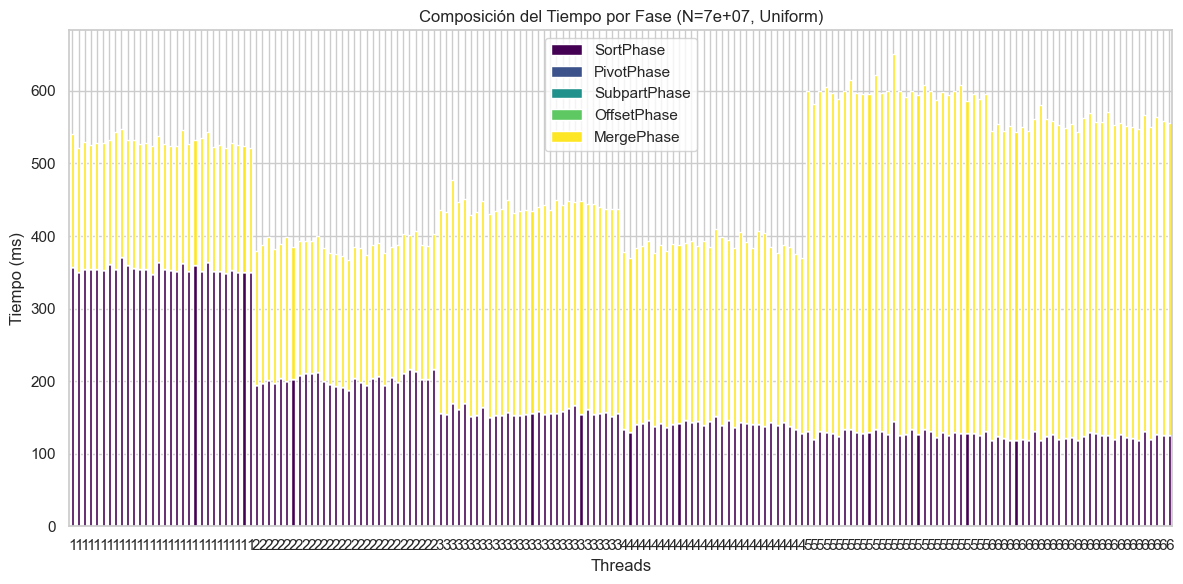

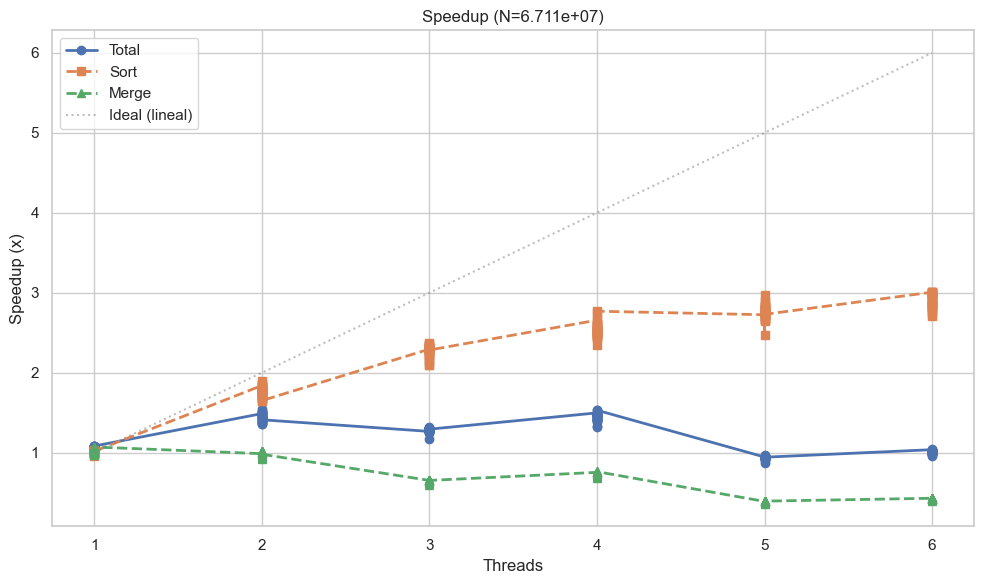

In [ ]:
if not is_nonempty(df_granular):
    print("Saltando Análisis 2: no existe 'benchmark_granular.csv' o está vacío.")
else:
    show_or_explain(
        require_columns(
            df_granular,
            [
                "Algorithm",
                "Distribution",
                "Threads",
                "InputSize",
                "TotalTime",
                "SortPhase",
                "PivotPhase",
                "SubpartPhase",
                "OffsetPhase",
                "MergePhase",
            ],
            "df_granular",
        ),
        "df_granular no tiene el formato esperado",
    )

    df = subset_granular(df_granular, algorithm="SampleMerge")

    # =====================
    # PARTE 1: fases (stacked)
    # =====================
    max_size = max_input_size(df)
    df_max_uni = subset_granular(df, distribution="Uniform", input_size=max_size)
    phases = ["SortPhase", "PivotPhase", "SubpartPhase", "OffsetPhase", "MergePhase"]

    if df_max_uni.empty:
        print("No hay datos SampleMerge/Uniform para el N máximo.")
    else:
        fig1, ax1 = plt.subplots(figsize=(12, 6))
        df_plot = df_max_uni.set_index("Threads")[phases].sort_index()
        df_plot.plot(kind="bar", stacked=True, ax=ax1, colormap="viridis")
        ax1.set_title(f"Composición del Tiempo por Fase (N={max_size:.3e}, Uniform)")
        ax1.set_ylabel("Tiempo (ms)")
        ax1.set_xlabel("Threads")
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()

        # =====================
        # PARTE 2: speedups (total vs fases)
        # =====================
        min_thread = int(df_max_uni["Threads"].min())
        base_row = df_max_uni[df_max_uni["Threads"] == min_thread].iloc[0]

        df_su = df_max_uni.copy().sort_values("Threads")
        df_su["Speedup_Total"] = base_row["TotalTime"] / df_su["TotalTime"]
        df_su["Speedup_Sort"] = base_row["SortPhase"] / df_su["SortPhase"]
        df_su["Speedup_Merge"] = base_row["MergePhase"] / df_su["MergePhase"]

        fig2, ax2 = plt.subplots(figsize=(10, 6))
        ax2.plot(df_su["Threads"], df_su["Speedup_Total"], marker="o", label="Total", linewidth=2)
        ax2.plot(df_su["Threads"], df_su["Speedup_Sort"], marker="s", linestyle="--", label="Sort", linewidth=2)
        ax2.plot(df_su["Threads"], df_su["Speedup_Merge"], marker="^", linestyle="--", label="Merge", linewidth=2)

        ax2.plot(
            [min_thread, int(df_su["Threads"].max())],
            [1, int(df_su["Threads"].max()) / min_thread],
            color="gray",
            alpha=0.5,
            linestyle=":",
            label="Ideal (lineal)",
        )

        ax2.set_title(f"Speedup (N={max_size:.3e})")
        ax2.set_xlabel("Threads")
        ax2.set_ylabel("Speedup (x)")
        ax2.legend()
        plt.tight_layout()
        plt.show()

## 4) Análisis 4 — Caché vs RAM (regresión segmentada)

Basado en `bandwith 4t.py` (nombre histórico).

Sirve para:
- Separar el comportamiento “in-cache” vs “out-of-cache” usando un umbral de L3.
- Ajustar regresiones por régimen para cuantificar el cambio de pendiente.
- Ver si el modelo $Merge \approx N\log_2(Threads)$ se comporta distinto al salir de caché.


ANÁLISIS SEGMENTADO (Caché vs RAM)

>>> Régimen: In-Cache (L3)
    R-squared: 0.8068
    Pendiente: 2.08e-06
    Cond. No.: 1.92e+06

>>> Régimen: Out-of-Cache (RAM)
    R-squared: 0.6638
    Pendiente: 1.62e-06
    Cond. No.: 7.23e+07


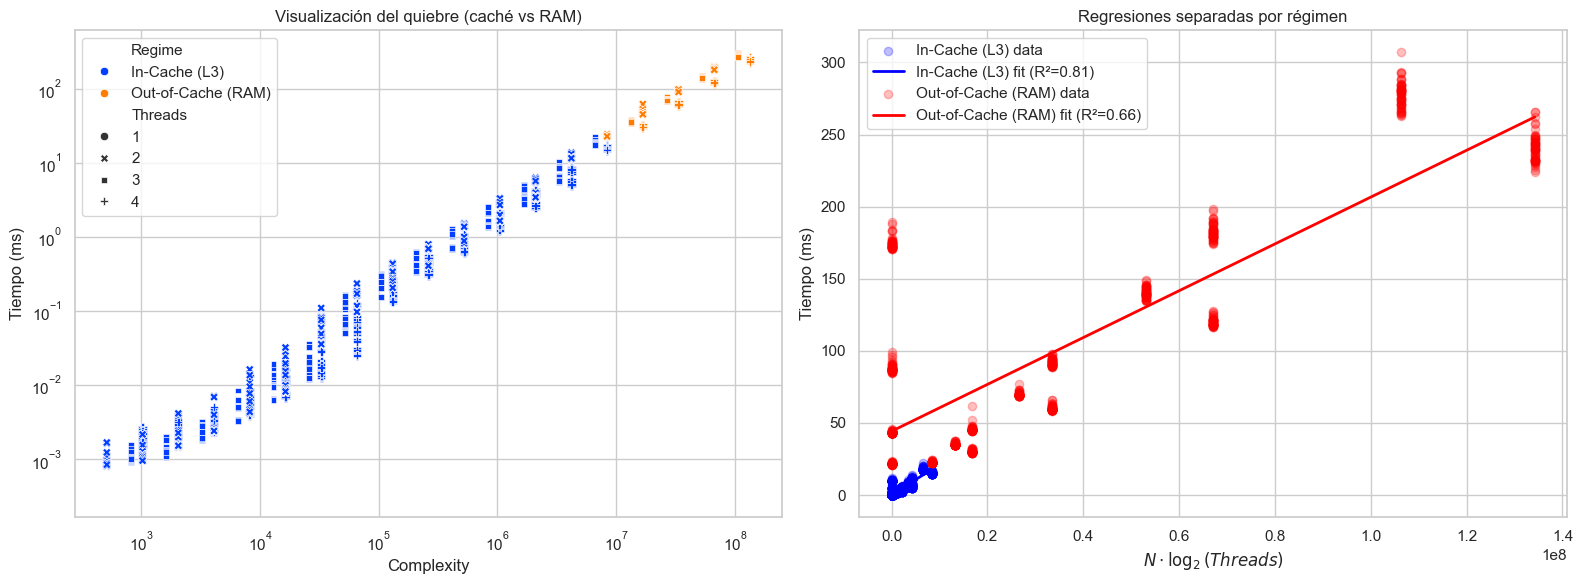

In [44]:
if not is_nonempty(df_granular):
    print("Saltando Análisis 4: no existe 'benchmark_granular.csv' o está vacío.")
else:
    df = subset_granular(df_granular, algorithm="SampleMerge")

    # Región escalable original: Threads <= 4
    df = df[df["Threads"] <= 4].copy()

    CACHE_THRESHOLD = int(L3_APPROX_ELEMENTS)  # ~20MB / 4 bytes
    df["Regime"] = np.where(df["InputSize"] < CACHE_THRESHOLD, "In-Cache (L3)", "Out-of-Cache (RAM)")

    # Modelo del script: N * log2(Threads)
    df["Complexity"] = df["InputSize"] * np.log2(df["Threads"])

    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    sns.scatterplot(data=df, x="Complexity", y="MergePhase", hue="Regime", style="Threads", ax=ax[0], palette="bright")
    ax[0].set_xscale("log")
    ax[0].set_yscale("log")
    ax[0].set_title("Visualización del quiebre (caché vs RAM)")
    ax[0].set_ylabel("Tiempo (ms)")

    print("\n" + "=" * 50)
    print("ANÁLISIS SEGMENTADO (Caché vs RAM)")
    print("=" * 50)

    colors = {"In-Cache (L3)": "blue", "Out-of-Cache (RAM)": "red"}

    for regime in ["In-Cache (L3)", "Out-of-Cache (RAM)"]:
        subset = df[df["Regime"] == regime].copy()
        if subset.empty:
            continue

        X = subset["Complexity"]
        y = subset["MergePhase"]
        model = ols_fit(y, X)

        print(f"\n>>> Régimen: {regime}")
        print(f"    R-squared: {model.rsquared:.4f}")
        print(f"    Pendiente: {model.params.iloc[1]:.2e}")
        print(f"    Cond. No.: {model.condition_number:.2e}")

        ax[1].scatter(X, y, color=colors[regime], alpha=0.25, label=f"{regime} data")

        x_pred = np.linspace(X.min(), X.max(), 200)
        y_pred = model.params.iloc[0] + model.params.iloc[1] * x_pred
        ax[1].plot(x_pred, y_pred, color=colors[regime], linewidth=2, label=f"{regime} fit (R²={model.rsquared:.2f})")

    ax[1].set_title("Regresiones separadas por régimen")
    ax[1].set_xlabel(r"$N \cdot \log_2(Threads)$")
    ax[1].set_ylabel("Tiempo (ms)")
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

## 6) Análisis 5 — Merge bottleneck: modelo $N\log_2(K)$ + ancho de banda efectivo

Basado en `bandwith_bottleneck.py`.

Sirve para:
- Ajustar una regresión con el modelo teórico $Merge \sim N\log_2(Threads)$.
- Visualizar saturación: tiempo de Merge vs Threads para N grandes.
- Estimar ancho de banda efectivo (GB/s) como evidencia de “memory wall”.


=== Regresión MergePhase con modelo N * log2(Threads) ===
R-squared: 0.9102


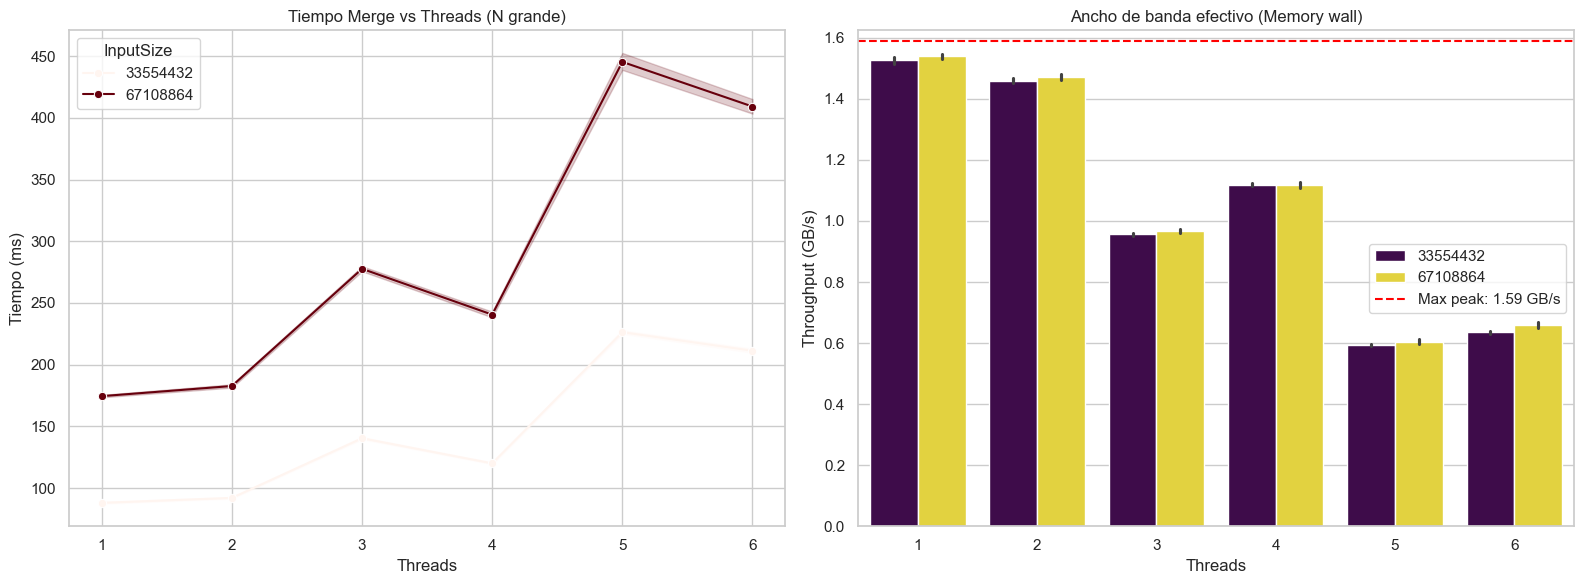

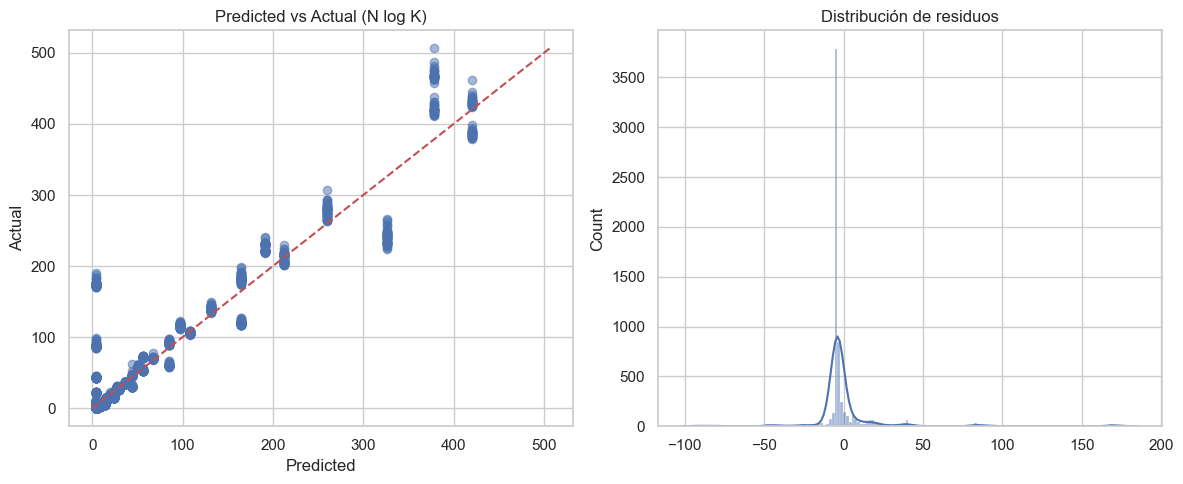

In [37]:
if not is_nonempty(df_granular):
    print("Saltando Análisis 5: no existe 'benchmark_granular.csv' o está vacío.")
else:
    df = subset_granular(df_granular, algorithm="SampleMerge")

    # Modelo teórico: N * log2(Threads)
    df = df.copy()
    df["Complexity_Merge"] = df["InputSize"] * np.log2(df["Threads"])

    X = df["Complexity_Merge"]
    y = df["MergePhase"]
    model = ols_fit(y, X)

    print("\n=== Regresión MergePhase con modelo N * log2(Threads) ===")
    print(f"R-squared: {model.rsquared:.4f}")

    # Ancho de banda efectivo (GB/s)
    df["Effective_Bandwidth_GBs"] = effective_bandwidth_gbs(df["InputSize"], df["MergePhase"], elem_bytes=4)

    # Nos quedamos con N grandes (mitad superior del rango)
    large_n_threshold = max_input_size(df) / 2
    df_large = df[df["InputSize"] >= large_n_threshold].copy()

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.lineplot(data=df_large, x="Threads", y="MergePhase", hue="InputSize", marker="o", palette="Reds", ax=axes[0])
    axes[0].set_title("Tiempo Merge vs Threads (N grande)")
    axes[0].set_ylabel("Tiempo (ms)")
    axes[0].set_xlabel("Threads")
    axes[0].grid(True)

    sns.barplot(data=df_large, x="Threads", y="Effective_Bandwidth_GBs", hue="InputSize", palette="viridis", ax=axes[1])
    max_bw = float(df_large["Effective_Bandwidth_GBs"].max()) if not df_large.empty else np.nan
    if np.isfinite(max_bw):
        axes[1].axhline(max_bw, color="red", linestyle="--", label=f"Max peak: {max_bw:.2f} GB/s")
    axes[1].set_title("Ancho de banda efectivo (Memory wall)")
    axes[1].set_ylabel("Throughput (GB/s)")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    # Residuos del modelo
    fig_res, ax_res = plt.subplots(1, 2, figsize=(12, 5))
    y_pred = model.predict(sm.add_constant(X))

    ax_res[0].scatter(y_pred, y, alpha=0.5)
    ax_res[0].plot([y.min(), y.max()], [y.min(), y.max()], "r--")
    ax_res[0].set_title("Predicted vs Actual (N log K)")
    ax_res[0].set_xlabel("Predicted")
    ax_res[0].set_ylabel("Actual")

    sns.histplot(model.resid, kde=True, ax=ax_res[1])
    ax_res[1].set_title("Distribución de residuos")

    plt.tight_layout()
    plt.show()